In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split

import cv2

# import pytorch for CNN model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
DEVICE

device(type='mps')

In [3]:
class Block(nn.Module):
    def __init__(self, inChannels, outChannels):
        super().__init__()
        # store the convolution and RELU layers
        self.conv1 = nn.Conv2d(inChannels, outChannels, 3)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(outChannels, outChannels, 3)
    def forward(self, x):
        # apply CONV => RELU => CONV block to the inputs and return it
        return self.conv2(self.relu(self.conv1(x)))

In [4]:
class Encoder(nn.Module):
    def __init__(self, channels=(4, 16, 32, 64)):
        super().__init__()
        # store the encoder blocks and maxpooling layer
        self.encBlocks = nn.ModuleList(
            [Block(channels[i], channels[i + 1]) for i in range(len(channels) - 1)]
        )
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        # initialize an empty list to store the intermediate outputs
        blockOutputs = []
        # loop through the encoder blocks
        for block in self.encBlocks:
            # pass the inputs through the current encoder block, store
            # the outputs, and then apply maxpooling on the output
            x = block(x)
            blockOutputs.append(x)
            x = self.pool(x)
        # return the list containing the intermediate outputs
        return blockOutputs


In [5]:
class Decoder(nn.Module):
    def __init__(self, channels=(64, 32, 16)):
        super().__init__()
        # initialize the number of channels, upsampler blocks, and
        # decoder blocks
        self.channels = channels
        self.upconvs = nn.ModuleList(
            [nn.ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
                 for i in range(len(channels) - 1)])
        self.dec_blocks = nn.ModuleList(
            [Block(channels[i], channels[i + 1])
                 for i in range(len(channels) - 1)])
    def forward(self, x, encFeatures):
        # loop through the number of channels
        for i in range(len(self.channels) - 1):
            # pass the inputs through the upsampler blocks
            x = self.upconvs[i](x)
            # crop the current features from the encoder blocks,
            # concatenate them with the current upsampled features,
            # and pass the concatenated output through the current
            # decoder block
            encFeat = self.crop(encFeatures[i], x)
            x = torch.cat([x, encFeat], dim=1)
            x = self.dec_blocks[i](x)
        # return the final decoder output
        return x
    def crop(self, encFeatures, x):
        # grab the dimensions of the inputs, and crop the encoder
        # features to match the dimensions
        (_, _, H, W) = x.shape
        encFeatures = transforms.CenterCrop([H, W])(encFeatures)
        # return the cropped features
        return encFeatures

In [6]:
INPUT_IMAGE_HEIGHT = 357
INPUT_IMAGE_WIDTH = 717

In [7]:
class UNet(nn.Module):
    def __init__(
        self,
        encChannels=(4, 16, 32, 64),
        decChannels=(64, 32, 16),
        nbClasses=4,
        retainDim=True,
        outSize=(INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH),
    ):
        super().__init__()
        # initialize the encoder and decoder
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)
        # initialize the regression head and store the class variables
        self.head = nn.Conv2d(decChannels[-1], nbClasses, 1)
        self.retainDim = retainDim
        self.outSize = outSize

    def forward(self, x):
        # grab the features from the encoder
        encFeatures = self.encoder(x)
        # pass the encoder features through decoder making sure that
        # their dimensions are suited for concatenation
        decFeatures = self.decoder(encFeatures[::-1][0], encFeatures[::-1][1:])
        # pass the decoder features through the regression head to
        # obtain the segmentation mask
        map = self.head(decFeatures)
        # check to see if we are retaining the original output
        # dimensions and if so, then resize the output to match them
        if self.retainDim:
            map = F.interpolate(map, self.outSize)
        # return the segmentation map
        return map


In [24]:
from OSSE_DataLoader import get_xarray, get_data_loaders

OSSE_train, eddies_train, OSSE_test =  get_xarray()

train_dataloader, val_dataloader = get_data_loaders(8, OSSE_train, eddies_train, 0, 3)

data_iter = iter(train_dataloader)

features, labels = next(data_iter)

my_cnn = UNet().to(DEVICE)
# my_cnn(torch.randn(1, 4, 357, 717).to(DEVICE))

# output = my_cnn(features.to(DEVICE))

# output.shape

# get predicted class
# pred = torch.max(my_cnn(features.to(DEVICE)), 1)[1]
# pred
# nn.Softmax(dim=1)(my_cnn(features.to(DEVICE)))

/Users/arthur/Dev/Hackathons/hackathon-sdd/OSSE_DataLoader.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_full[:idx_split, :, :, :], dtype=torch.float32)
/Users/arthur/Dev/Hackathons/hackathon-sdd/OSSE_DataLoader.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_full[:idx_split, :, :, :], dtype=torch.int64)
/Users/arthur/Dev/Hackathons/hackathon-sdd/OSSE_DataLoader.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_full[idx_split:, :, :, :], dtype=torch.fl

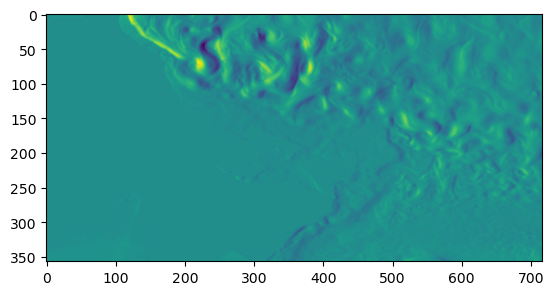

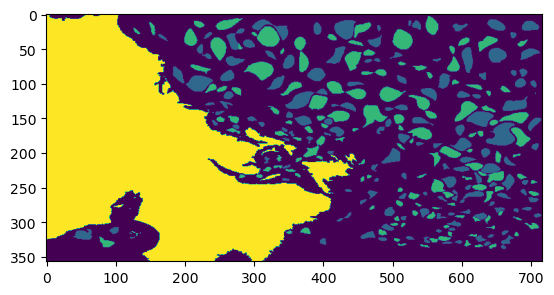

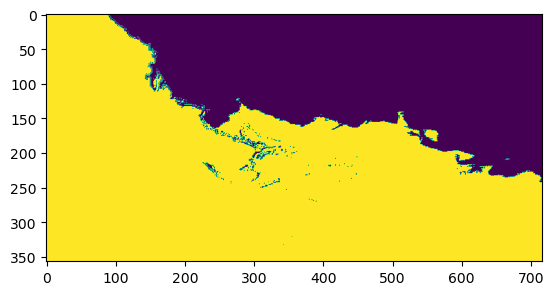

In [9]:
# softmax on 1st dimension
output = nn.Softmax(dim=1)(my_cnn(features.to(DEVICE)))

# get predicted class
pred = torch.max(output, 1)[1]
pred[1]

# show the image of 1st sample
plt.imshow(features[1, 0, :, :].cpu().numpy())
plt.show()

# show the label of 1st sample
plt.imshow(labels[1, 0, :, :].cpu().numpy())
plt.show()

# show the predicted label of 1st sample
plt.imshow(pred[1, :, :].cpu().numpy())
plt.show()


In [10]:
np.unique(pred[1, :, :].detach().cpu().numpy())

array([1, 2, 3])

In [11]:
import numpy as np

data_iter = iter(train_dataloader)

features, labels = next(data_iter)

features.shape, labels.shape

np.unique(features)

array([-2.409116 , -2.397963 , -2.3915386, ..., 31.039139 , 31.205057 ,
       31.22811  ], dtype=float32)

In [12]:
# # Example of target with class indices
# loss = nn.CrossEntropyLoss()
# input = torch.randn(3, 5, requires_grad=True)
# target = torch.empty(3, dtype=torch.long).random_(5)
# output = loss(input, target)
# output.backward()
# # Example of target with class probabilities
# input = torch.randn(3, 5, requires_grad=True)
# target = torch.randn(3, 5).softmax(dim=1)
# output = loss(input, target)
# output.backward()

In [25]:
# initialize our UNet model
unet = UNet().to(DEVICE)
# initialize loss function and optimizer
lossFunc = nn.BCEWithLogitsLoss()
opt = optim.Adam(unet.parameters())
# calculate steps per epoch for training and test set
# trainSteps = 20
# testSteps = len(testDS) // config.BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}


In [26]:
# loop over epochs
from numpy import dtype


print("[INFO] training the network...")
# startTime = time.time()
NUM_EPOCHS = 20

for epoch in range(NUM_EPOCHS):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	# loop over the training set
	for (i, (x, y)) in enumerate(train_dataloader):
		# send the input to the device
		(x, y) = (x.to(DEVICE), y.to(DEVICE))
		# perform a forward pass and calculate the training loss
		pred = unet(x)

		# one hot encode the labels
		y = torch.nn.functional.one_hot(y, num_classes=4)
		y = y.view(-1, 4, 357, 717)
		y = y.type(torch.float32)

		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for (x, y) in val_dataloader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = unet(x)

			# one hot encode the labels
			y = torch.nn.functional.one_hot(y, num_classes=4, )
			y = y.view(-1, 4, 357, 717)
			# convert y to float32
			y = y.type(torch.float32)

			totalTestLoss += lossFunc(pred, y)
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss
	avgTestLoss = totalTestLoss
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(epoch + 1, NUM_EPOCHS))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
# endTime = time.time()
# print("[INFO] total time taken to train the model: {:.2f}s".format(
# 	endTime - startTime))

[INFO] training the network...


In [ ]:
np.unique(y.cpu().numpy())

array([0., 1., 2., 3.], dtype=float32)